# Homework 3 
### ASTROINFORMATICS

## Problem 1

We learned this week that the posterior pdf for $b$, the tail probability when
flipping a coin, with a flat prior in the range 0-1, is
$$ p(b \,|\, k, N ) = C \, b^k \, (1-b)^{N-k}, $$
where the normalization constant $C$ can be determined from the condition $\int_0^1 p(b\,|\,k,N)\, db = 1$.

Get a coin, flip it 8 times and record the results.

a) plot $p(b \,|\, k, N )$ after each flip. Every time show the previous (prior) $p(b)$
and the posterior $p(b)$. 

b) After all 8 flips, what is the probability that your coin strongly prefers
heads over tails: what is the probability $p(b<0.25\,|\, k, N )$)? 


## Problem 2

Fit polynomials of up to the 5th order to the provided dataset.
Use BIC to find the best model for this dataset.

## Problem 3 

Apply Bayesian Blocks Algorithm to period distribution (logP) of LINEAR variable stars. 
Plot histograms on both linear and log scale. Compare the result to classical (Knuth's) 
uniform bin width histogram. 


### Some useful definitions and functions

In [83]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from astroML.datasets import fetch_LINEAR_geneva
from astroML.plotting import setup_text_plots
from astroML.plotting import hist
setup_text_plots(fontsize=8, usetex=True)

## Problem 1: the coin flip

/home/devya_divi/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/devya_divi/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/devya_divi/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/devya_divi/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/devya_divi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Total coin tosses: 8
Number of tails  : 5
The probability that heads is prefered over tails is : 0.011060


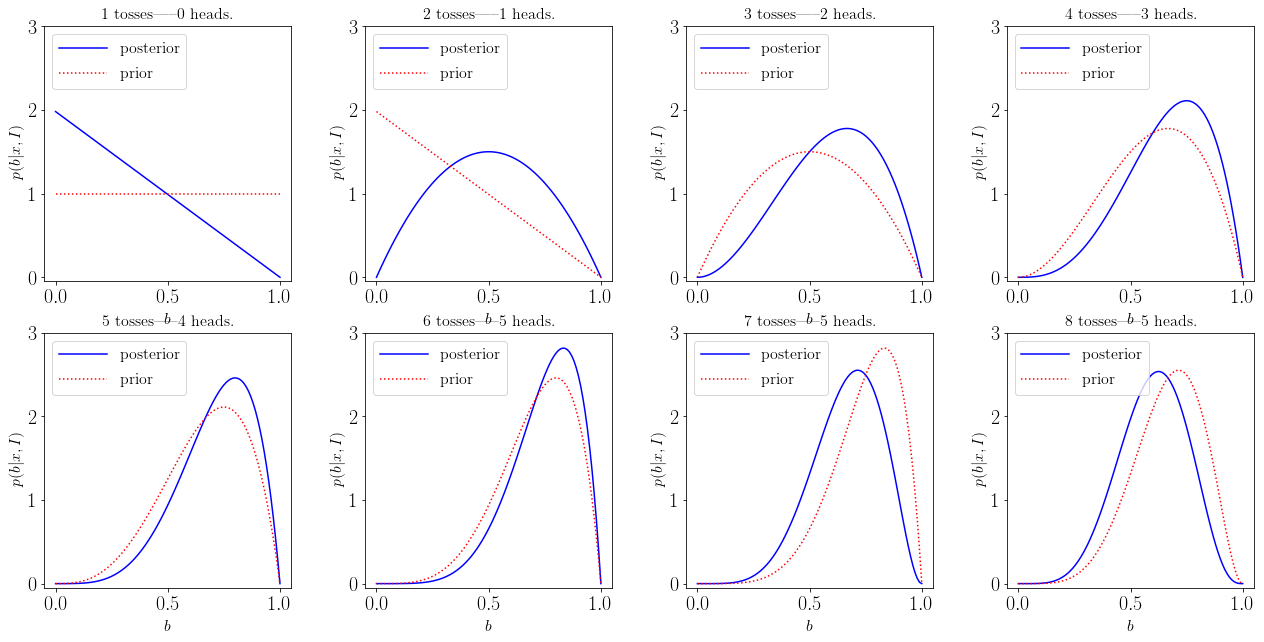

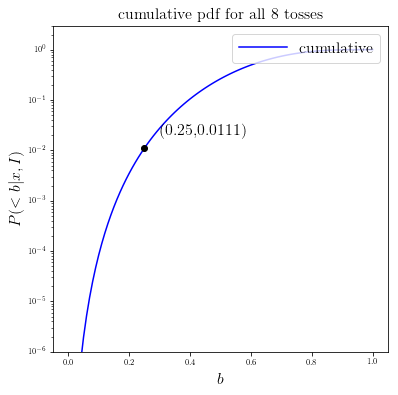

In [84]:
from scipy.stats import norm
np.random.seed(42)
# (0:head, 1: tail)
flipData = [0, 1, 1, 1, 1, 1, 0, 0]

toss=len(flipData)
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.3, bottom=0.1)
b = np.linspace(0, 1, 101)
db = b[1] - b[0]

def p(n,k):
    # compute the probability p(b)
    p_b = b ** k * (1 - b) ** (n - k)
    p_b /= p_b.sum()
    p_b /= db
    # compute the gaussian approximation
    b0 = k * 1. / n
    sigb = np.sqrt(b0*(1-b0)/n)
    p_g = norm(b0, sigb).pdf(b)
    return(p_b,p_g)

def cuml(n,k):
    cuml_p_b = p(n,k)[0].cumsum()
    cuml_p_b /= cuml_p_b[-1]
    
    cuml_p_g = p(n,k)[1].cumsum()
    cuml_p_g /= cuml_p_g[-1]
    return(cuml_p_b,cuml_p_g)
    
for i in range(1,len(flipData)+1):
    n=len(flipData[:i]) #total number of tosses
    k=np.sum(flipData[:i]) #total number of tails
    # Plot the results
    p_b,p_g=p(n,k)
    ax = fig.add_subplot(np.ceil(toss/4) ,4,i)
    ax.plot(b, p_b, '-b',label='posterior')
    ax.set_ylim(-0.05, 3)
    ax.set_xlabel('$b$',size=toss*2)
    ax.set_ylabel('$p(b|x,I)$',size=toss*2)
    plt.tick_params(labelsize=toss*2.5)
    plt.title("%d tosses-----%d heads."%(i,k),size=toss*2)
    n=len(flipData[0:(i-1)])
    k=np.sum(flipData[0:(i-1)])    
    ax.plot(b, p(n,k)[0], ':',c='red',label='prior')
    plt.legend(loc=2,prop={'size': toss*2})
    plt.tick_params(labelsize=toss*2.5)


n=len(flipData) #total number of tosses
k=np.sum(flipData) #total number of tails
cuml_p_b, cuml_p_g= cuml(n,k)

p_tails=cuml_p_b[b==0.25]    
print("Total coin tosses: %d"%n)
print("Number of tails  : %d"%k)
print("The probability that heads is prefered over tails is : %.6f"%p_tails)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(b, cuml_p_b, '-b',label='cumulative')
ax.plot(0.25,p_tails,'ok')
plt.title('cumulative pdf for all %d tosses'%n,size=toss*2)
plt.text(0.3,p_tails+0.01,'(%.2f,%.4f)'%(0.25,p_tails),size=toss*2)
plt.legend(loc=1,prop={'size':toss*2})
ax.set_yscale('log')

ax.set_xlabel('$b$',size=toss*2)
ax.set_ylabel('$P(<b|x,I)$',size=toss*2)
ax.set_ylim(1E-6, 3)
plt.show()

## Problem 2: use BIC to find the best polynomial model for a given dataset

In [85]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles
from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, x, y, sigma_y, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, x, y, sigma_y, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, x, y, sigma_y, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

In [86]:
# generate (noisy) data
np.random.seed(0)
Ndata = 22
x = np.linspace(0, 3, Ndata)[1:-1]
sigma_y = 0.1 + 0*x
y = np.random.normal(np.sin(x) * x, sigma_y) 


CHI2:
     best linear model: 349.6591351367567
  best quadratic model: 99.3313525184048
      best cubic model: 10.182096497796792
best biquadratic model: 10.090493155695128
    best quintic model: 9.753601467341257
CHI2 per degree of freedom:
     best linear model: 17.482956756837833
  best quadratic model: 5.227965922021305
      best cubic model: 0.5656720276553773
best biquadratic model: 0.5935584209232428
    best quintic model: 0.6096000917088286


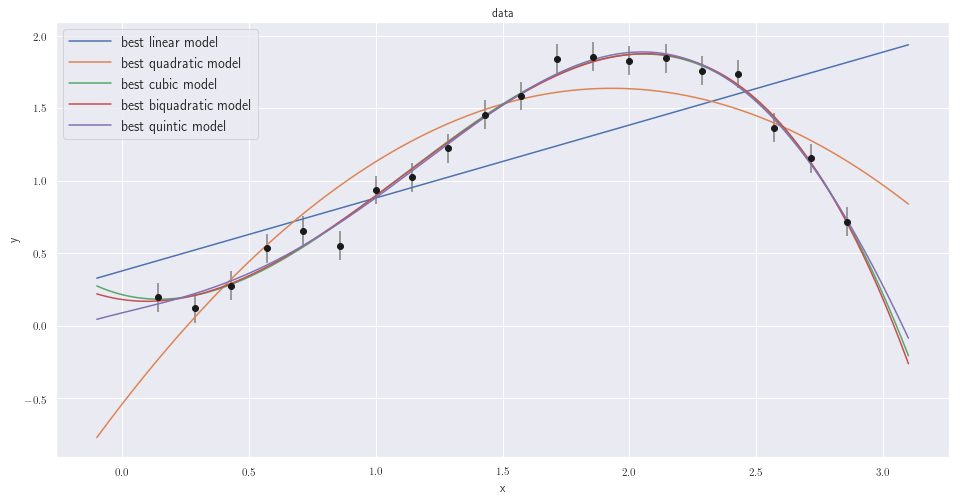

In [87]:

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, x, y, sigma_y)
theta2 = best_theta(2, x, y, sigma_y)
theta3 = best_theta(3, x, y, sigma_y)
theta4 = best_theta(4, x, y, sigma_y)
theta5 = best_theta(5, x, y, sigma_y)
# generate best fit lines on a fine grid 
xfit = np.linspace(-0.1, 3.1, 1000)
yfit1 = polynomial_fit(theta1, xfit)
yfit2 = polynomial_fit(theta2, xfit)
yfit3 = polynomial_fit(theta3, xfit)
yfit4 = polynomial_fit(theta4, xfit)
yfit5 = polynomial_fit(theta5, xfit)
# and compute chi2 per degree of freedom: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) 
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) 
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2)
chi24 = np.sum(((y-polynomial_fit(theta4, x))/sigma_y)**2)
chi25 = np.sum(((y-polynomial_fit(theta5, x))/sigma_y)**2)
# the number of fitted parameters is 2, 3, 4, 5, 6
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata - 3)
chi2dof3 = chi23/(Ndata - 4)
chi2dof4 = chi24/(Ndata - 5)
chi2dof5 = chi25/(Ndata - 6)

print("CHI2:")
print('     best linear model:', chi21)
print('  best quadratic model:', chi22)
print('      best cubic model:', chi23)
print('best biquadratic model:', chi24)
print('    best quintic model:', chi25)
print("CHI2 per degree of freedom:")
print('     best linear model:', chi2dof1)
print('  best quadratic model:', chi2dof2)
print('      best cubic model:', chi2dof3)
print('best biquadratic model:', chi2dof4)
print('    best quintic model:', chi2dof5)
# plot 
fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xfit, polynomial_fit(theta1, xfit), label='best linear model')
ax.plot(xfit, polynomial_fit(theta2, xfit), label='best quadratic model')
ax.plot(xfit, polynomial_fit(theta3, xfit), label='best cubic model')
ax.plot(xfit, polynomial_fit(theta4, xfit), label='best biquadratic model')
ax.plot(xfit, polynomial_fit(theta5, xfit), label='best quintic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

In [88]:
BIC_1=chi21 + 2* np.log(Ndata)
BIC_2=chi22 + 3* np.log(Ndata)
BIC_3=chi23 + 4* np.log(Ndata)
BIC_4=chi24 + 5* np.log(Ndata)
BIC_5=chi25 + 6* np.log(Ndata)
print("BIC:")
print('model           chi2       k    k*ln(N)          BIC')
print('linear    :    %7.3f     2   %7.3f        %7.3f' %(chi21, 2*np.log(Ndata), BIC_1))
print('quadratic :    %7.3f     3   %7.3f        %7.3f' %(chi22, 3*np.log(Ndata), BIC_2))
print('cubic     :    %7.3f     4   %7.3f        %7.3f' %(chi23, 4*np.log(Ndata), BIC_3))
print('biqudratic:    %7.3f     5   %7.3f        %7.3f' %(chi24, 5*np.log(Ndata), BIC_4))
print('quintic   :    %7.3f     6   %7.3f        %7.3f' %(chi25, 6*np.log(Ndata), BIC_5))

BIC:
model           chi2       k    k*ln(N)          BIC
linear    :    349.659     2     6.182        355.841
quadratic :     99.331     3     9.273        108.604
cubic     :     10.182     4    12.364         22.546
biqudratic:     10.090     5    15.455         25.546
quintic   :      9.754     6    18.546         28.300


As we can easily observe, BIC for CUBIC model is minimum, with no significant improvements in higher order fits.
Also from graph, we can see that the cubic fits the data nicely.
So using BIC, we can state that CUBIC model is the best fit for the data.

## Problem 3
Compare Bayesian Blocks Algorithm and classical histogram
on a sample of periodic variable stars.

In [89]:
# fetch data
data = fetch_LINEAR_geneva()
x = data['logP']

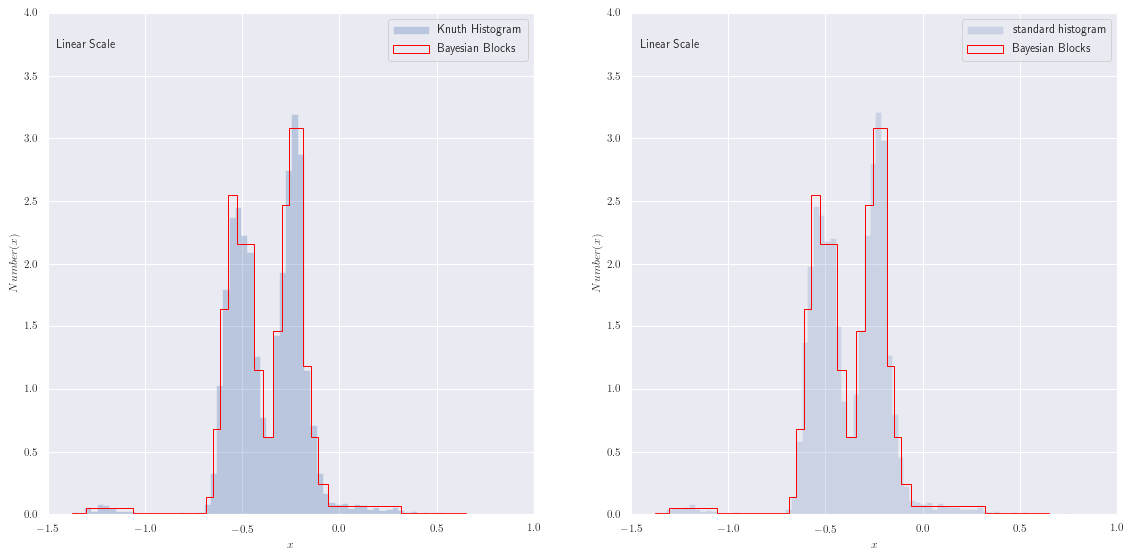

In [90]:
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.15)
ax = fig.add_subplot(121)

    # plot the results
hist(x, bins='knuth', ax=ax, density=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
hist(x, bins='blocks', ax=ax, density=True,
         histtype='step', color='red', alpha=0.99,
         label="Bayesian Blocks")
  
    # label the plot
ax.text(0.02, 0.95, "Linear Scale", ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$Number(x)$')
ax.legend(loc='upper right', prop=dict(size=12))

ax.set_xlabel('$x$')

ax.set_xlim(-1.5, 1.0)
ax.set_ylim(0.0, 4.0)


ax = fig.add_subplot(122)

    # plot the results
hist(x, bins=100, histtype='stepfilled',
         alpha=0.2, label='standard histogram',density=True)
hist(x, bins='blocks', ax=ax, density=True,
         histtype='step', color='red', alpha=0.99,
         label="Bayesian Blocks")
  
    # label the plot
ax.text(0.02, 0.95, "Linear Scale", ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$Number(x)$')
ax.legend(loc='upper right', prop=dict(size=12))

ax.set_xlabel('$x$')

ax.set_xlim(-1.5, 1.0)
ax.set_ylim(0.0, 4.0)

plt.show()

/home/devya_divi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/devya_divi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


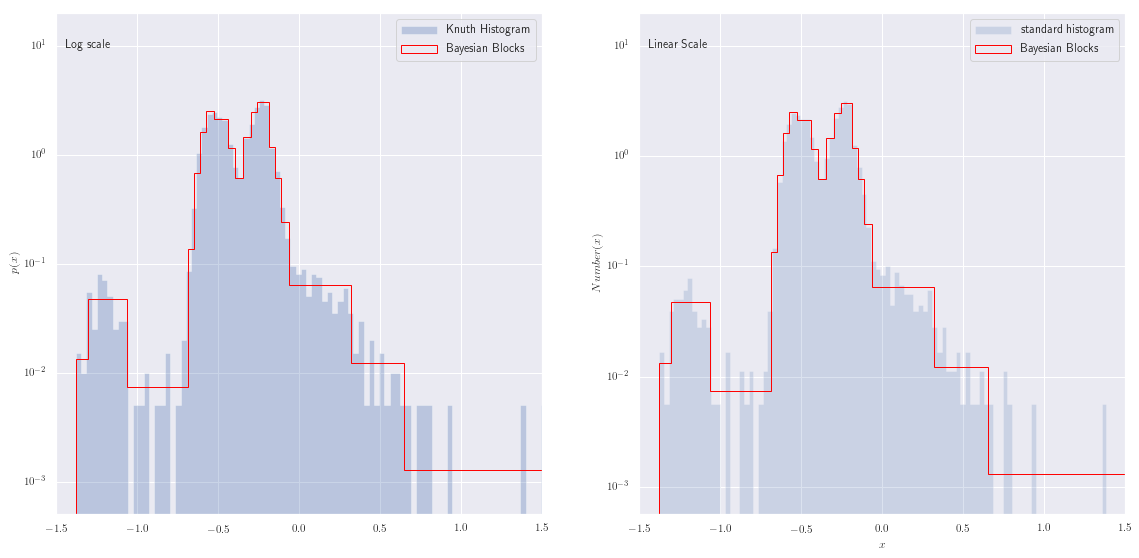

In [91]:

fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.15)
ax = fig.add_subplot(121)

    # plot the results
hist(x, bins='knuth', ax=ax, density=True,log=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
hist(x, bins='blocks', ax=ax, density=True,
         histtype='step', color='red', alpha=0.99,
         label="Bayesian Blocks")
  
    # label the plot
ax.text(0.02, 0.95, "Log scale", ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$p(x)$')
ax.legend(loc='upper right', prop=dict(size=12))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0.0, 20.0)


ax = fig.add_subplot(122)

    # plot the results
hist(x, bins=100, histtype='stepfilled',
         alpha=0.2, label='standard histogram',density=True, log=True)
hist(x, bins='blocks', ax=ax, density=True,
         histtype='step', color='red', alpha=0.99,
         label="Bayesian Blocks")
  
    # label the plot
ax.text(0.02, 0.95, "Linear Scale", ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$Number(x)$')
ax.legend(loc='upper right', prop=dict(size=12))

ax.set_xlabel('$x$')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0.0, 20.0)

plt.show()